In [25]:
#!/usr/bin/env python3
# 3D animation using rotation matrix

from utils.utils import preprocess_watch_data
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from math import sin,cos
from numpy import random

df = preprocess_watch_data("data/examples/example_Apple_Watch.csv",save=False,plot=False)
omega = np.array(df[['gyr_x','gyr_y','gyr_z']])
time = df['gyr_t']
thetas = [np.zeros(3)]
Rs = [np.eye(3,3)]
bases = [np.eye(3,3)]
def get_rotation_matrix_from_yaw_pitch_roll(roll,pitch,yaw):
    ## according to right hand rule,
    # yaw = z rotation
    # pitch = y rotation
    # roll = x rotation
    R_x = np.array([[1,0,0],[0,cos(roll),-sin(roll)],[0,sin(roll),cos(roll)]])
    R_y = np.array([[cos(pitch),0,sin(pitch)],[0,1,0],[-sin(pitch),0,cos(pitch)]])
    R_z = np.array([[cos(yaw),-sin(yaw),0],[sin(yaw),cos(yaw),0],[0,0,1]])
    R = R_z @ R_y @ R_x
    return R
def get_yaw_pitch_roll(n):
    return omega[n]*(time[n]-time[n-1])+thetas[n-1]
def get_rotated_basis(basis,R):
    return R @ basis
def ypr_to_quat(roll,pitch,yaw):
    cy = cos(yaw * 0.5)
    sy = sin(yaw * 0.5)
    cp = cos(pitch * 0.5)
    sp = sin(pitch * 0.5)
    cr = cos(roll * 0.5)
    sr = sin(roll * 0.5)

    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy

    return np.array([w,x,y,z])

In [26]:
thetas

[array([0., 0., 0.])]

In [27]:
Qs = []
rpy = []
for i,_ in enumerate(time):
    if (i==0):
        # don't have delta t, next
        continue
    theta = get_yaw_pitch_roll(i)
    thetas.append(theta)
    Qs.append(ypr_to_quat(*theta))

In [30]:
len(thetas)*3

4029

In [31]:
X = np.array(thetas)
print(len(X))
np.save('rpy.npy',X)

1343


In [16]:
for i,_ in enumerate(time):
    if (i==0):
        # don't have delta t, next
        continue
    theta = get_yaw_pitch_roll(i)
    thetas.append(theta)
    R = get_rotation_matrix_from_yaw_pitch_roll(*theta)
    
    Rs.append(R)
    bases.append(get_rotated_basis(bases[0],R))


In [11]:
X = np.array(Rs)
np.save('rs.npy',X)

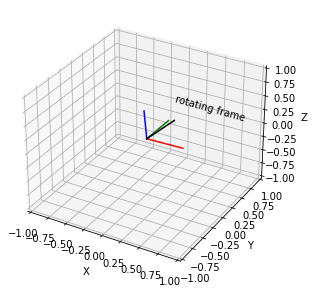

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
from pytransform3d.plot_utils import Frame
from pytransform3d import rotations as pr


def update_frame(step, n_frames, frame):
    R = bases[step]
    A2B = np.eye(4)
    A2B[:3, :3] = R
    frame.set_data(A2B)
    return frame


if __name__ == "__main__":
    n_frames = len(time)

    fig = plt.figure(figsize=(5, 5))

    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))
    ax.set_zlim((-1, 1))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    frame = Frame(np.eye(4), label="rotating frame", s=0.5)
    frame.add_frame(ax)

    anim = animation.FuncAnimation(
        fig, update_frame, n_frames, fargs=(n_frames, frame), interval=50,
        blit=False)
    anim.save('basic_animation.mp4', fps=100, extra_args=['-vcodec', 'libx264'])

    plt.show()